### Building an Intrusion Detection System for IoT Networks

Install the required packages

In [1]:
!nvidia-smi

Sat Aug 30 02:10:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

create an isolated workspace for TensorFlow development package management

In [2]:
!python3 -m venv --without-pip tf
!source tf/bin/activate && pip install pip

In [3]:
!source tf/bin/activate

In [4]:
!pip install --upgrade pip

In [5]:
!pip install tensorflow[and-cuda]

In [6]:
!python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

2025-08-30 02:10:44.951234: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756519844.988872    3140 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756519845.006047    3140 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756519845.043792    3140 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756519845.043832    3140 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756519845.043841    3140 computation_placer.cc:177] computation placer alr

Install TensorFlow Model Optimization

In [7]:
!pip install --user --upgrade tensorflow-model-optimization

Import the necessary libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

Load the RT-IoT2022 Dataset

In [9]:
# Load the dataset
df = pd.read_csv('/content/RT_IOT2022_v1.csv')

Preprocessing steps (take this out)

In [10]:
# Drop non-numeric columns that shouldn't be scaled
non_numeric_cols = ['proto', 'service', 'Attack_type']
numeric_df = df.drop(columns=non_numeric_cols)

# Apply StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_df)

# Convert back to DataFrame for clarity
scaled_df = pd.DataFrame(X_scaled, columns=numeric_df.columns)

# Display first few rows
print(scaled_df.head())

         no  id.orig_p  id.resp_p  flow_duration  fwd_pkts_tot  bwd_pkts_tot  \
0 -1.215900   0.211202   0.165266       0.216931      0.301353        0.0936   
1 -1.215868   0.865405   0.165266       0.215946      0.301353        0.0936   
2 -1.215835   0.530753   0.165266       0.217796      0.301353        0.0936   
3 -1.215802   1.376665   0.165266       0.216542      0.301353        0.0936   
4 -1.215769   0.862468   0.165266       0.216090      0.301353        0.0936   

   fwd_data_pkts_tot  bwd_data_pkts_tot  fwd_pkts_per_sec  bwd_pkts_per_sec  \
0            0.07786           0.067497          -0.94887         -0.948656   
1            0.07786           0.067497          -0.94887         -0.948656   
2            0.07786           0.067497          -0.94887         -0.948656   
3            0.07786           0.067497          -0.94887         -0.948656   
4            0.07786           0.067497          -0.94887         -0.948656   

   ...  active.avg  active.std  idle.min  id

In [11]:
# Define attack types
benign_attacks = ['MQTT_Publish', 'Thing_Speak', 'Wipro_bulb']
harmful_attacks = [
    'DOS_SYN_Hping', 'ARP_poisioning', 'NMAP_UDP_SCAN',
    'NMAP_XMAS_TREE_SCAN', 'NMAP_OS_DETECTION', 'NMAP_TCP_scan',
    'DDOS_Slowloris', 'Metasploit_Brute_Force_SSH', 'NMAP_FIN_SCAN'
]

# Count occurrences
benign_count = df['Attack_type'].isin(benign_attacks).sum()
harmful_count = df['Attack_type'].isin(harmful_attacks).sum()

# Output result
print(f" Number of benign attacks:  {benign_count}")
print(f" Number of harmful attacks: {harmful_count}")


 Number of benign attacks:  12507
 Number of harmful attacks: 110610


Fix class imbalance with SMOTE- Logistic Regression

In [12]:
!pip install imblearn

Logistic Regression Model (Baseline Model)

In [13]:
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

# Define attack categories
benign_attacks = ['MQTT_Publish', 'Thing_Speak', 'Wipro_bulb']
harmful_attacks = [
    'DOS_SYN_Hping', 'ARP_poisioning', 'NMAP_UDP_SCAN',
    'NMAP_XMAS_TREE_SCAN', 'NMAP_OS_DETECTION', 'NMAP_TCP_scan',
    'DDOS_Slowloris', 'Metasploit_Brute_Force_SSH', 'NMAP_FIN_SCAN'
]

# Create binary labels
df['attack_label'] = df['Attack_type'].apply(
    lambda x: 1 if x in harmful_attacks else (0 if x in benign_attacks else np.nan)
)
df = df.dropna(subset=['attack_label'])
y = df['attack_label'].astype(int)

# Select numeric features and scale them
non_features = ['proto', 'service', 'Attack_type', 'attack_label']
X_raw = df.drop(columns=non_features)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Train a Logistic Regression model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_balanced, y_train_balanced)

# Evaluate on the test set
y_pred = clf.predict(X_test)

print("\n Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Benign", "Harmful"]))

print("\n Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


 Classification Report:
              precision    recall  f1-score   support

      Benign       0.79      0.98      0.88      2501
     Harmful       1.00      0.97      0.98     22123

    accuracy                           0.97     24624
   macro avg       0.90      0.98      0.93     24624
weighted avg       0.98      0.97      0.97     24624


 Confusion Matrix:
[[ 2463    38]
 [  642 21481]]


Random Forest Model


 Classification Report (Random Forest):
                            precision    recall  f1-score   support

            ARP_poisioning       0.99      1.00      0.99      1550
            DDOS_Slowloris       0.93      0.95      0.94       107
             DOS_SYN_Hping       1.00      1.00      1.00     18932
              MQTT_Publish       1.00      1.00      1.00       829
Metasploit_Brute_Force_SSH       1.00      0.86      0.92         7
             NMAP_FIN_SCAN       1.00      0.67      0.80         6
         NMAP_OS_DETECTION       1.00      1.00      1.00       400
             NMAP_TCP_scan       1.00      1.00      1.00       200
             NMAP_UDP_SCAN       0.99      0.98      0.99       518
       NMAP_XMAS_TREE_SCAN       1.00      1.00      1.00       402
               Thing_Speak       1.00      0.99      1.00      1622
                Wipro_bulb       1.00      0.98      0.99        51

                  accuracy                           1.00     24624
     

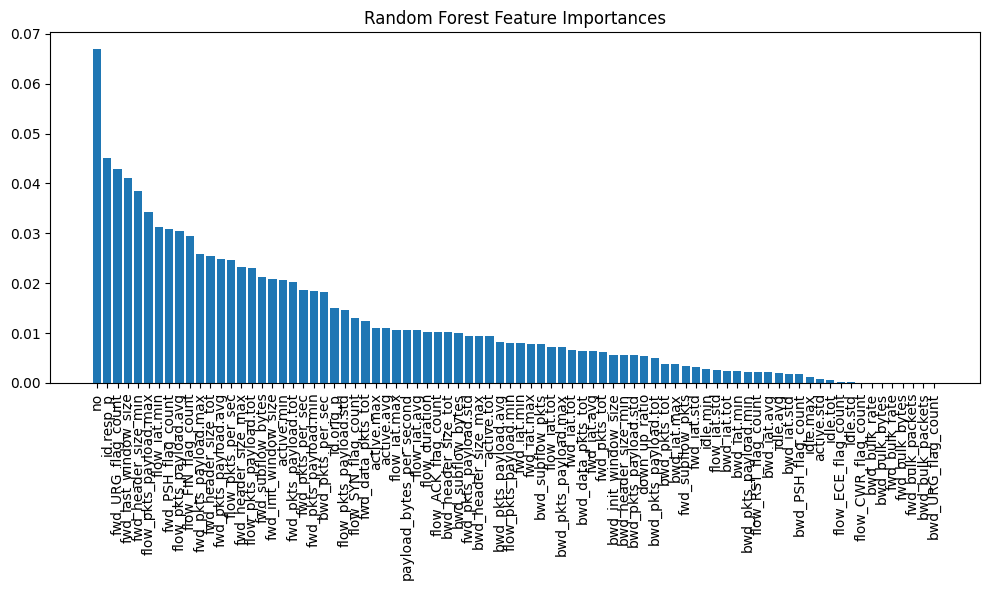

In [14]:
# Random Forest Multiclass Classification

from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
import joblib

# Load + shuffle
df1 = pd.read_csv('/content/RT_IOT2022_v1.csv')
df1 = df1.sample(frac=1, random_state=42).reset_index(drop=True)

valid_attacks = [
    'MQTT_Publish', 'Thing_Speak', 'Wipro_bulb',            # benign
    'DOS_SYN_Hping', 'ARP_poisioning', 'NMAP_UDP_SCAN',
    'NMAP_XMAS_TREE_SCAN', 'NMAP_OS_DETECTION', 'NMAP_TCP_scan',
    'DDOS_Slowloris', 'Metasploit_Brute_Force_SSH', 'NMAP_FIN_SCAN'  # harmful
]
df1 = df1[df1['Attack_type'].isin(valid_attacks)].copy()

# Labels (multiclass)
le = LabelEncoder()
df1['attack_label'] = le.fit_transform(df1['Attack_type'])
y = df1['attack_label'].values
num_classes = len(le.classes_)

# Features + scaling
non_features = ['proto', 'service', 'Attack_type', 'attack_label']
X_raw = df1.drop(columns=non_features)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# Save scaler for later use
joblib.dump(scaler, 'scaler_rf.joblib')

# Train/val/test split
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y, test_size=0.20, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)  # 60/20/20

# Class weights (helps rare classes)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}

# Train Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    class_weight=class_weight_dict,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# Evaluate
y_pred = rf.predict(X_test)

print("\n Classification Report (Random Forest):")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("\n Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Save model
joblib.dump(rf, 'random_forest_model.joblib')
print("\n Random Forest model saved as 'random_forest_model.joblib'.")

# Feature Importance

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Random Forest Feature Importances")
plt.bar(range(X_raw.shape[1]), importances[indices], align="center")
plt.xticks(range(X_raw.shape[1]), X_raw.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

MLP Classifier Code with SMOTE and Evaluation

In [15]:
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Load dataset
df2 = pd.read_csv('/content/RT_IOT2022_v1.csv')

# Define attack types
benign_attacks = ['MQTT_Publish', 'Thing_Speak', 'Wipro_bulb']
harmful_attacks = [
    'DOS_SYN_Hping', 'ARP_poisioning', 'NMAP_UDP_SCAN',
    'NMAP_XMAS_TREE_SCAN', 'NMAP_OS_DETECTION', 'NMAP_TCP_scan',
    'DDOS_Slowloris', 'Metasploit_Brute_Force_SSH', 'NMAP_FIN_SCAN'
]

# Create binary label
df2['attack_label'] = df2['Attack_type'].apply(
    lambda x: 1 if x in harmful_attacks else (0 if x in benign_attacks else np.nan)
)
df2 = df2.dropna(subset=['attack_label'])
y = df2['attack_label'].astype(int)

# Prepare features
non_features = ['proto', 'service', 'Attack_type', 'attack_label']
X_raw = df2.drop(columns=non_features)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Build MLP Model
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train Model with EarlyStopping
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_balanced, y_train_balanced,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Evaluation
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

print("\n Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Benign", "Harmful"]))

print("\n Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Epoch 1/50
4425/4425 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9693 - loss: 0.0997 - val_accuracy: 0.9887 - val_loss: 0.0418
Epoch 2/50
4425/4425 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9910 - loss: 0.0321 - val_accuracy: 0.9930 - val_loss: 0.0370
Epoch 3/50
4425/4425 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.9938 - loss: 0.0214 - val_accuracy: 0.9975 - val_loss: 0.0124
Epoch 4/50
4425/4425 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9949 - loss: 0.0172 - val_accuracy: 0.9975 - val_loss: 0.0127
Epoch 5/50
4425/4425 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9955 - loss: 0.0158 - val_accuracy: 0.9958 - val_loss: 0.0197
Epoch 6/50
4425/4425 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.9954 - loss: 0.0175 - val_accuracy: 0.9981 - val_loss: 0.0104
Epoch 7/50
4425/4425 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9953 - loss: 0.0226 - val_accuracy: 0.9981 - val_loss: 0.0140
Epoch 8/50
4425/4425 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9956 - loss: 0

MLP for Multiclass Attack Classification

In [16]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers, callbacks

# Load and Shuffle the Dataset
df3 = pd.read_csv('/content/RT_IOT2022_v1.csv')
df3 = df3.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle

# Filter only defined attacks (benign or harmful)
valid_attacks = [
    'MQTT_Publish', 'Thing_Speak', 'Wipro_bulb',  # benign
    'DOS_SYN_Hping', 'ARP_poisioning', 'NMAP_UDP_SCAN',
    'NMAP_XMAS_TREE_SCAN', 'NMAP_OS_DETECTION', 'NMAP_TCP_scan',
    'DDOS_Slowloris', 'Metasploit_Brute_Force_SSH', 'NMAP_FIN_SCAN'  # harmful
]

df3_filtered = df3[df3['Attack_type'].isin(valid_attacks)].copy()

# Encode Attack_type as multiclass labels
le = LabelEncoder()
df3_filtered['attack_label'] = le.fit_transform(df3_filtered['Attack_type'])
y = to_categorical(df3_filtered['attack_label'])  # one-hot for multiclass

# Prepare Features
X_raw = df3_filtered.drop(columns=['proto', 'service', 'Attack_type', 'attack_label'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# Split into Train, Validation, Test
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)  # 0.25 of 80% = 20%

# Build MLP Model for Multiclass Classification
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(y_train.shape[1], activation='softmax')  # multiclass
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model with EarlyStopping
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stop],
                    verbose=1)

# Evaluate Model
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\n Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))

print("\n Confusion Matrix:")
print(confusion_matrix(y_true_classes, y_pred_classes))

Epoch 1/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9276 - loss: 0.2823 - val_accuracy: 0.9792 - val_loss: 0.0528
Epoch 2/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.9823 - loss: 0.0687 - val_accuracy: 0.9866 - val_loss: 0.0414
Epoch 3/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9869 - loss: 0.0429 - val_accuracy: 0.9896 - val_loss: 0.0384
Epoch 4/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9891 - loss: 0.0365 - val_accuracy: 0.9919 - val_loss: 0.0297
Epoch 5/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9899 - loss: 0.0345 - val_accuracy: 0.9938 - val_loss: 0.0270
Epoch 6/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.9910 - loss: 0.0297 - val_accuracy: 0.9944 - val_loss: 0.0266
Epoch 7/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9918 - loss: 0.0276 - val_accuracy: 0.9932 - val_loss: 0.0241
Epoch 8/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9925 - loss: 0.02

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Quantized MLP Model for IoT Deployment

In [17]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras.utils import to_categorical

# Load & Shuffle Dataset
df4 = pd.read_csv('/content/RT_IOT2022_v1.csv')
df4 = df4.sample(frac=1, random_state=42).reset_index(drop=True)

# Filter Valid Attacks
valid_attacks = [
    'MQTT_Publish', 'Thing_Speak', 'Wipro_bulb',
    'DOS_SYN_Hping', 'ARP_poisioning', 'NMAP_UDP_SCAN',
    'NMAP_XMAS_TREE_SCAN', 'NMAP_OS_DETECTION', 'NMAP_TCP_scan',
    'DDOS_Slowloris', 'Metasploit_Brute_Force_SSH', 'NMAP_FIN_SCAN'
]
df4 = df4[df4['Attack_type'].isin(valid_attacks)].copy()

# Encode Labels
le = LabelEncoder()
df4['attack_label'] = le.fit_transform(df4['Attack_type'])
y_int = df4['attack_label'].values
y_cat = to_categorical(y_int)

# Feature Preprocessing
non_features = ['proto', 'service', 'Attack_type', 'attack_label']
X_raw = df4.drop(columns=non_features)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# Split Dataset
X_temp, X_test, y_temp_cat, y_test_cat, y_temp_int, y_test_int = train_test_split(
    X_scaled, y_cat, y_int, test_size=0.2, stratify=y_int, random_state=42)

X_train, X_val, y_train_cat, y_val_cat, y_train_int, y_val_int = train_test_split(
    X_temp, y_temp_cat, y_temp_int, test_size=0.25, stratify=y_temp_int, random_state=42)

# Compute Class Weights
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train_int),
                                     y=y_train_int)
class_weight_dict = dict(enumerate(class_weights))

# Define Lightweight MLP Model
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(y_train_cat.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train, y_train_cat,
          validation_data=(X_val, y_val_cat),
          epochs=50,
          batch_size=32,
          class_weight=class_weight_dict,
          callbacks=[early_stop],
          verbose=1)

# Evaluate on Test Set
y_pred = model.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1)
y_true_class = np.argmax(y_test_cat, axis=1)

print("\n Classification Report:")
print(classification_report(y_true_class, y_pred_class, target_names=le.classes_))
print("\n Confusion Matrix:")
print(confusion_matrix(y_true_class, y_pred_class))

# Quantize the Model for IoT (TFLite)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Enable post-training quantization
tflite_model = converter.convert()

# Save the Quantized Model
with open("quantized_iot_model.tflite", "wb") as f:
    f.write(tflite_model)

print("\n Model successfully quantized and saved as 'quantized_iot_model.tflite'")


Epoch 1/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8482 - loss: 0.9614 - val_accuracy: 0.9676 - val_loss: 0.1152
Epoch 2/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9718 - loss: 0.2183 - val_accuracy: 0.9760 - val_loss: 0.0834
Epoch 3/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9803 - loss: 0.1617 - val_accuracy: 0.9338 - val_loss: 0.2257
Epoch 4/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9774 - loss: 0.1933 - val_accuracy: 0.9827 - val_loss: 0.0813
Epoch 5/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9871 - loss: 0.1081 - val_accuracy: 0.9870 - val_loss: 0.0659
Epoch 6/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9864 - loss: 0.1387 - val_accuracy: 0.9881 - val_loss: 0.0607
Epoch 7/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9871 - loss: 0.1339 - val_accuracy: 0.9883 - val_loss: 0.0665
Epoch 8/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9898 - loss: 0.078

Emulate the IoT device Raspberry Pi

Saved artifact at '/tmp/tmpthef3m3v'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 50), dtype=tf.float32, name='keras_tensor_16')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  139311784996560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139311784998288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139314389058000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139314389058768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139314389061648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139314389058576: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Average Inference Time: 0.004 ms
Standard Deviation: 0.002 ms


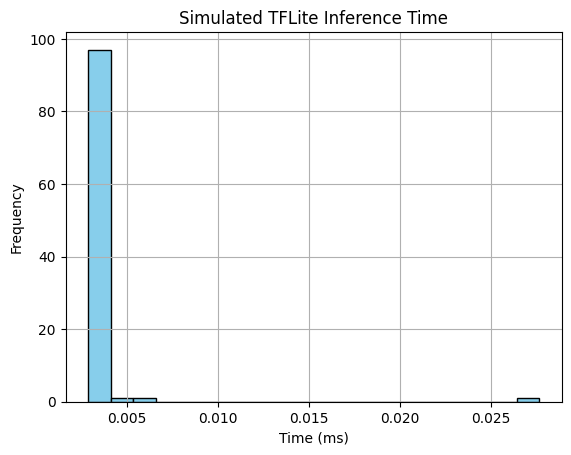

In [18]:
import time

# Build a small MLP model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(50,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(12, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy')

# Convert to quantized TFLite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Load with TFLite Interpreter
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Measure inference times
times = []
for _ in range(100):
    input_data = np.random.rand(1, 50).astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    start = time.time()
    interpreter.invoke()
    _ = interpreter.get_tensor(output_details[0]['index'])
    end = time.time()
    times.append((end - start) * 1000)  # ms

# Display results
print(f"Average Inference Time: {np.mean(times):.3f} ms")
print(f"Standard Deviation: {np.std(times):.3f} ms")

plt.hist(times, bins=20, color='skyblue', edgecolor='black')
plt.title("Simulated TFLite Inference Time")
plt.xlabel("Time (ms)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


Final MLP Combo Model- Original MLP  ->  TFLite (dynamic range)  +  TFLite (INT8)

In [19]:
import os
import joblib
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import models, layers, callbacks

# Load + shuffle + filter
df5 = pd.read_csv('/content/RT_IOT2022_v1.csv')
df5 = df5.sample(frac=1, random_state=42).reset_index(drop=True)

valid_attacks = [
    'MQTT_Publish', 'Thing_Speak', 'Wipro_bulb',            # benign
    'DOS_SYN_Hping', 'ARP_poisioning', 'NMAP_UDP_SCAN',
    'NMAP_XMAS_TREE_SCAN', 'NMAP_OS_DETECTION', 'NMAP_TCP_scan',
    'DDOS_Slowloris', 'Metasploit_Brute_Force_SSH', 'NMAP_FIN_SCAN'  # harmful
]
df5 = df5[df5['Attack_type'].isin(valid_attacks)].copy()

# Labels (multiclass)
le = LabelEncoder()
df5['attack_label'] = le.fit_transform(df5['Attack_type'])
y = df5['attack_label'].values
num_classes = len(le.classes_)

# Features + scaling
non_features = ['proto', 'service', 'Attack_type', 'attack_label']
X_raw = df5.drop(columns=non_features)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# Save the scaler to reuse on-device or server-side preprocessing
joblib.dump(scaler, 'scaler.joblib')

# Split train/val/test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y, test_size=0.20, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)  # => 60/20/20

# Class weights (helps rare classes)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}

# Build lightweight MLP
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stop = callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate original MLP
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

print("\n Classification Report (Original MLP):")
print(classification_report(y_test, y_pred, target_names=le.classes_))
print("\n Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Save original MLP
original_path = 'original_mlp_model.h5'
model.save(original_path)

# TFLite (Dynamic Range) quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]   # dynamic-range quant
tflite_dynamic = converter.convert()

dynamic_path = 'model_dynamic.tflite'
with open(dynamic_path, 'wb') as f:
    f.write(tflite_dynamic)

# TFLite (Full INT8) quantization
#     Uses representative data for proper calibration.
#     Note: INT8 IO requires int8 tensors on-device; keep scaler in pipeline.
def representative_data_gen():
    # Take a small sample from training data (float32) for calibration
    for i in range(min(200, X_train.shape[0])):
        yield [X_train[i:i+1].astype(np.float32)]

converter_int8 = tf.lite.TFLiteConverter.from_keras_model(model)
converter_int8.optimizations = [tf.lite.Optimize.DEFAULT]
converter_int8.representative_dataset = representative_data_gen
converter_int8.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_int8.inference_input_type = tf.int8
converter_int8.inference_output_type = tf.int8
tflite_int8 = converter_int8.convert()

int8_path = 'model_int8.tflite'
with open(int8_path, 'wb') as f:
    f.write(tflite_int8)

# Size comparison
def size_kb(p): return os.path.getsize(p) / 1024
print("\n File sizes:")
print(f" - Original Keras (.h5): {size_kb(original_path):.2f} KB")
print(f" - TFLite Dynamic:       {size_kb(dynamic_path):.2f} KB")
print(f" - TFLite INT8:          {size_kb(int8_path):.2f} KB")

reduction_dyn = 100 * (size_kb(original_path) - size_kb(dynamic_path)) / size_kb(original_path)
reduction_int8 = 100 * (size_kb(original_path) - size_kb(int8_path)) / size_kb(original_path)
print(f"\n Reduction vs Original — Dynamic: {reduction_dyn:.1f}% | INT8: {reduction_int8:.1f}%")

# quick TFLite sanity check
def tflite_infer(model_path, sample):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    inp = interpreter.get_input_details()[0]
    out = interpreter.get_output_details()[0]
    x = sample.astype(np.float32)

    # For INT8 model, quantize input using input scale/zero-point
    if 'int8' in model_path:
        scale, zero = inp['quantization']
        x = (x / scale + zero).astype(np.int8)

    interpreter.set_tensor(inp['index'], x)
    interpreter.invoke()
    y = interpreter.get_tensor(out['index'])

    # Dequantize INT8 output back to float for readability
    if 'int8' in model_path:
        scale, zero = out['quantization']
        y = (y.astype(np.float32) - zero) * scale
    return y

sample = X_test[:1]
_ = tflite_infer(dynamic_path, sample)
_ = tflite_infer(int8_path, sample)
print("\n TFLite models loaded and ran a sample inference successfully.")


Epoch 1/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8573 - loss: 1.1129 - val_accuracy: 0.9724 - val_loss: 0.1112
Epoch 2/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9655 - loss: 0.2629 - val_accuracy: 0.9740 - val_loss: 0.0985
Epoch 3/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9757 - loss: 0.1618 - val_accuracy: 0.9754 - val_loss: 0.0807
Epoch 4/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9761 - loss: 0.1647 - val_accuracy: 0.9857 - val_loss: 0.0600
Epoch 5/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9852 - loss: 0.1360 - val_accuracy: 0.9845 - val_loss: 0.0749
Epoch 6/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9852 - loss: 0.1081 - val_accuracy: 0.9867 - val_loss: 0.0614
Epoch 7/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9852 - loss: 0.1635 - val_accuracy: 0.9884 - val_loss: 0.0597
Epoch 8/50
2309/2309 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9895 - loss: 0.099


 Classification Report (Original MLP):
                            precision    recall  f1-score   support

            ARP_poisioning       0.95      0.92      0.93      1550
            DDOS_Slowloris       0.72      1.00      0.84       107
             DOS_SYN_Hping       1.00      1.00      1.00     18932
              MQTT_Publish       1.00      1.00      1.00       829
Metasploit_Brute_Force_SSH       1.00      0.86      0.92         7
             NMAP_FIN_SCAN       0.10      0.67      0.17         6
         NMAP_OS_DETECTION       0.99      1.00      1.00       400
             NMAP_TCP_scan       0.99      0.99      0.99       200
             NMAP_UDP_SCAN       0.97      0.92      0.94       518
       NMAP_XMAS_TREE_SCAN       1.00      1.00      1.00       402
               Thing_Speak       0.98      0.94      0.96      1622
                Wipro_bulb       0.46      0.96      0.62        51

                  accuracy                           0.99     24624
      

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


TFLite Inference Performance Benchmark on the RT-IoT2022 data model

IoT Attack Detection - TFLite Inference Benchmark
Creating IoT Attack Detection Model...
Model created with 7852 parameters
Input features: 83
Output classes: 12
Quantizing model for TFLite...
Saved artifact at '/tmp/tmpnbtxwy21'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 83), dtype=tf.float32, name='keras_tensor_68')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  139311784995984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139311784987536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139311784989072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139311784999824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139311784995792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139311784998864: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model successfully quantized and saved as 'quantized_iot_model.tflite'
Starting TFLite inference benchmark w

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


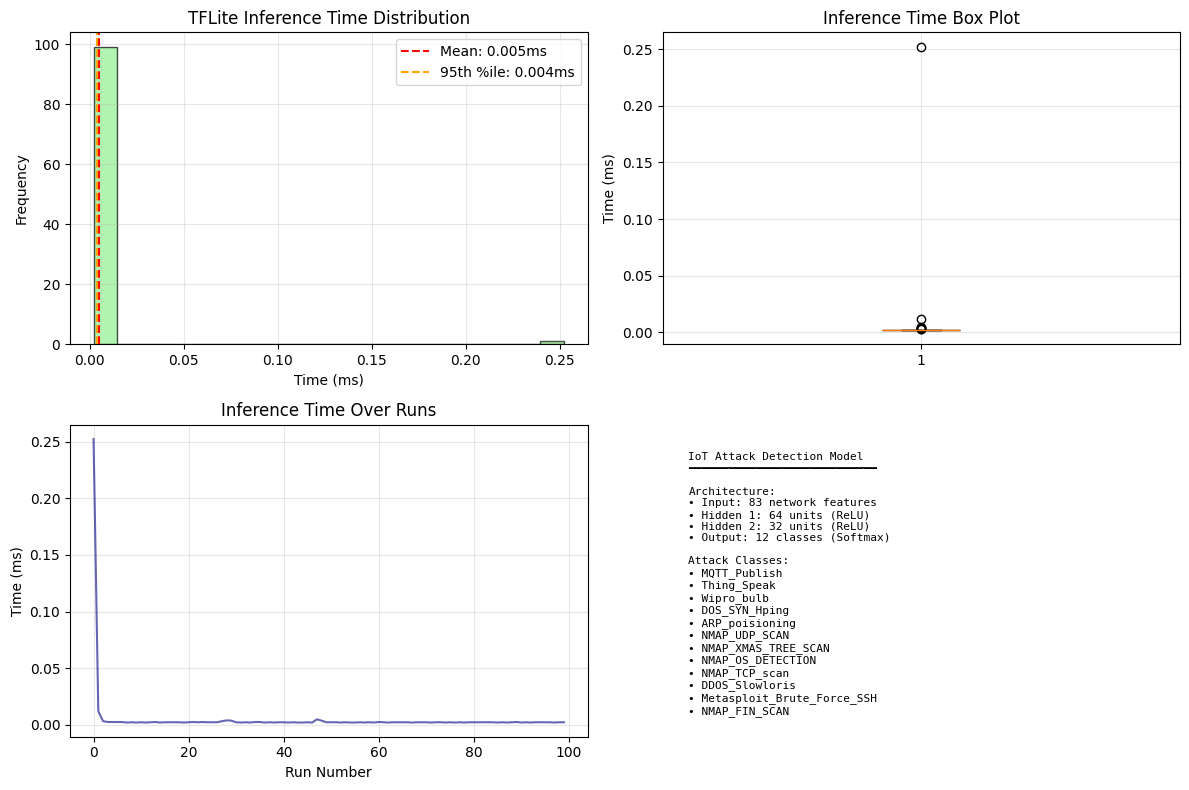


Detailed results saved to 'tflite_benchmark_results.csv'

Formatted for comparison with original code:
Average Inference Time: 0.005 ms
Standard Deviation: 0.025 ms
Loaded real dataset with 123117 samples
Error with real data: Cannot set tensor: Dimension mismatch. Got 82 but expected 83 for dimension 1 of input 0.
Falling back to synthetic benchmark
IoT Attack Detection - TFLite Inference Benchmark
Creating IoT Attack Detection Model...
Model created with 7852 parameters
Input features: 83
Output classes: 12
Quantizing model for TFLite...


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Saved artifact at '/tmp/tmpm3_vtcny'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 83), dtype=tf.float32, name='keras_tensor_72')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  139311784986960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139311784987728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139311784998480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139311785000208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139311784986768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139311784984656: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model successfully quantized and saved as 'quantized_iot_model.tflite'
Starting TFLite inference benchmark with 100 runs...
Input shape: [ 1 83]
Output shape: [ 1 12]
Completed 20/100 inferences
Completed 40/100 inferences
Completed 60/100 inferences
Completed 80/100 inferences
Completed 100/100 infe

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


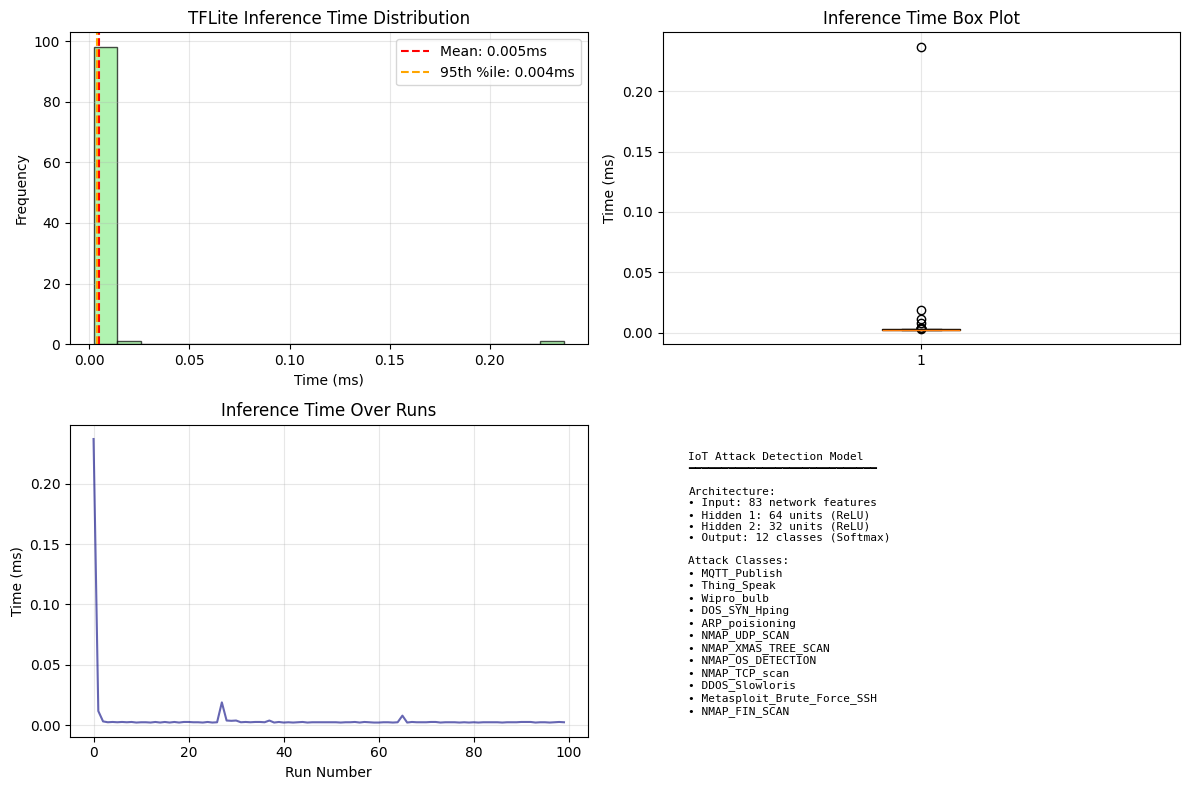


Detailed results saved to 'tflite_benchmark_results.csv'

Formatted for comparison with original code:
Average Inference Time: 0.005 ms
Standard Deviation: 0.023 ms


In [29]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras.utils import to_categorical

def create_and_train_iot_model():
    print("Creating IoT Attack Detection Model...")

    valid_attacks = [
        'MQTT_Publish', 'Thing_Speak', 'Wipro_bulb',
        'DOS_SYN_Hping', 'ARP_poisioning', 'NMAP_UDP_SCAN',
        'NMAP_XMAS_TREE_SCAN', 'NMAP_OS_DETECTION', 'NMAP_TCP_scan',
        'DDOS_Slowloris', 'Metasploit_Brute_Force_SSH', 'NMAP_FIN_SCAN'
    ]

    # Model parameters based on RT_IOT2022 dataset
    input_features = 83  # Typical feature count after preprocessing
    num_classes = len(valid_attacks)

    model = models.Sequential([
        layers.Input(shape=(input_features,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    print(f"Model created with {model.count_params()} parameters")
    print(f"Input features: {input_features}")
    print(f"Output classes: {num_classes}")

    return model, input_features, num_classes, valid_attacks

def quantize_model(model):

    print("Quantizing model for TFLite...")

    # Convert to quantized TFLite model
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Enable post-training quantization
    tflite_model = converter.convert()

    # Save the quantized model
    with open("quantized_iot_model.tflite", "wb") as f:
        f.write(tflite_model)

    print("Model successfully quantized and saved as 'quantized_iot_model.tflite'")
    return tflite_model

def benchmark_tflite_inference(tflite_model, input_features, num_runs=100):

    print(f"Starting TFLite inference benchmark with {num_runs} runs...")

    # Load with TFLite Interpreter
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    print(f"Input shape: {input_details[0]['shape']}")
    print(f"Output shape: {output_details[0]['shape']}")

    # Measure inference times
    times = []
    for i in range(num_runs):
        # Generate realistic IoT network traffic features (normalized/scaled)
        input_data = np.random.normal(0, 0.5, (1, input_features)).astype(np.float32)

        # Set input tensor
        interpreter.set_tensor(input_details[0]['index'], input_data)

        # Measure inference time
        start = time.time()
        interpreter.invoke()
        output = interpreter.get_tensor(output_details[0]['index'])
        end = time.time()

        times.append((end - start) * 1000)  # Convert to milliseconds

        # Progress indicator
        if (i + 1) % 20 == 0:
            print(f"Completed {i + 1}/{num_runs} inferences")

    return times

def analyze_and_plot_results(times, valid_attacks):

    times = np.array(times)

    # Calculate comprehensive statistics
    mean_time = np.mean(times)
    std_time = np.std(times)
    min_time = np.min(times)
    max_time = np.max(times)
    median_time = np.median(times)
    p95_time = np.percentile(times, 95)
    p99_time = np.percentile(times, 99)

    # Display results (matching your original format)
    print("\n" + "="*60)
    print("TFLITE INFERENCE BENCHMARK RESULTS")
    print("="*60)
    print(f"Number of runs: {len(times)}")
    print(f"Average Inference Time: {mean_time:.3f} ms")
    print(f"Median Inference Time: {median_time:.3f} ms")
    print(f"Standard Deviation: {std_time:.3f} ms")
    print(f"Min Time: {min_time:.3f} ms")
    print(f"Max Time: {max_time:.3f} ms")
    print(f"95th Percentile: {p95_time:.3f} ms")
    print(f"99th Percentile: {p99_time:.3f} ms")
    print(f"Coefficient of Variation: {(std_time/mean_time)*100:.1f}%")
    print(f"Estimated Throughput: ~{1000/mean_time:.0f} inferences/second")
    print(f"Real-time capable: {'✅ Yes' if mean_time < 10 else '⚠️ Depends on requirements'}")

    # Create visualization (matching your original histogram style)
    plt.figure(figsize=(12, 8))

    # Main histogram
    plt.subplot(2, 2, 1)
    plt.hist(times, bins=20, color='lightgreen', edgecolor='black', alpha=0.7)
    plt.title("TFLite Inference Time Distribution")
    plt.xlabel("Time (ms)")
    plt.ylabel("Frequency")
    plt.grid(True, alpha=0.3)
    plt.axvline(mean_time, color='red', linestyle='--', label=f'Mean: {mean_time:.3f}ms')
    plt.axvline(p95_time, color='orange', linestyle='--', label=f'95th %ile: {p95_time:.3f}ms')
    plt.legend()

    # Box plot for outlier analysis
    plt.subplot(2, 2, 2)
    plt.boxplot(times, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    plt.title("Inference Time Box Plot")
    plt.ylabel("Time (ms)")
    plt.grid(True, alpha=0.3)

    # Time series plot
    plt.subplot(2, 2, 3)
    plt.plot(times, color='navy', alpha=0.6)
    plt.title("Inference Time Over Runs")
    plt.xlabel("Run Number")
    plt.ylabel("Time (ms)")
    plt.grid(True, alpha=0.3)

    # Model info and attack classes
    plt.subplot(2, 2, 4)
    plt.axis('off')
    info_text = f"""
IoT Attack Detection Model
━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Architecture:
• Input: 83 network features
• Hidden 1: 64 units (ReLU)
• Hidden 2: 32 units (ReLU)
• Output: {len(valid_attacks)} classes (Softmax)

Attack Classes:
"""
    for i, attack in enumerate(valid_attacks, 1):
        info_text += f"• {attack}\n"

    plt.text(0.05, 0.95, info_text, transform=plt.gca().transAxes,
             fontsize=8, verticalalignment='top', fontfamily='monospace')

    plt.tight_layout()
    plt.show()

    return {
        'mean': mean_time,
        'std': std_time,
        'min': min_time,
        'max': max_time,
        'median': median_time,
        'p95': p95_time,
        'p99': p99_time,
        'times': times,
        'throughput': 1000/mean_time
    }

def main():
    """
    Main function to run the complete TFLite benchmark.
    """
    print("IoT Attack Detection - TFLite Inference Benchmark")
    print("="*50)

    # Step 1: Create and train model (or load existing)
    model, input_features, num_classes, valid_attacks = create_and_train_iot_model()

    # Step 2: Quantize model for TFLite
    tflite_model = quantize_model(model)

    # Step 3: Benchmark inference performance
    times = benchmark_tflite_inference(tflite_model, input_features, num_runs=100)

    # Step 4: Analyze and visualize results
    results = analyze_and_plot_results(times, valid_attacks)

    # Step 5: Save detailed results
    results_df = pd.DataFrame({
        'run_number': range(1, len(times) + 1),
        'inference_time_ms': times
    })
    results_df.to_csv('tflite_benchmark_results.csv', index=False)
    print(f"\nDetailed results saved to 'tflite_benchmark_results.csv'")

    # Optional: Compare with your original results format
    print(f"\nFormatted for comparison with original code:")
    print(f"Average Inference Time: {results['mean']:.3f} ms")
    print(f"Standard Deviation: {results['std']:.3f} ms")

    return results

# Additional utility function for loading and testing with real data
def benchmark_with_real_data(model_path="quantized_iot_model.tflite", data_path=None):
    """
    Optional function to benchmark with real RT_IOT2022 data if available.
    """
    if data_path is None:
        print("No real data path provided, using synthetic data")
        return main()

    try:
        # Load real data
        df = pd.read_csv(data_path)
        print(f"Loaded real dataset with {len(df)} samples")

        # Use real samples for benchmarking
        interpreter = tf.lite.Interpreter(model_path=model_path)
        interpreter.allocate_tensors()

        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()

        # Preprocess a subset of real data for testing
        non_features = ['proto', 'service', 'Attack_type']
        X_real = df.drop(columns=[col for col in non_features if col in df.columns])

        # Scale the data
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_real.iloc[:100])  # First 100 samples

        times = []
        for i in range(len(X_scaled)):
            input_data = X_scaled[i:i+1].astype(np.float32)
            interpreter.set_tensor(input_details[0]['index'], input_data)

            start = time.time()
            interpreter.invoke()
            _ = interpreter.get_tensor(output_details[0]['index'])
            end = time.time()

            times.append((end - start) * 1000)

        print(f"Real data benchmark - Avg: {np.mean(times):.3f}ms, Std: {np.std(times):.3f}ms")
        return times

    except Exception as e:
        print(f"Error with real data: {e}")
        print("Falling back to synthetic benchmark")
        return main()

if __name__ == "__main__":
    # Run the main benchmark
    results = main()

    # Using the actual RT_IOT2022 dataset
    benchmark_with_real_data(data_path="/content/RT_IOT2022_v1.csv")